<a href="https://colab.research.google.com/github/rasecotineb/datascience/blob/master/sentiment-analysis/Twitter_Analisis_de_Sentimientos_PUCP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de sentimientos: Percepción sobre las Clínicas Privadas en el Perú frente al COVID-19


La estructura es la siguiente:
  * train
     * tweets a favor
     * tweets en contra 
  * test
     * tweets a favor 
     * tweets en contra

#Train section

In [ ]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1YQ4N_aUKh1pZlMSshW3wxWWsZAN6D1gcL47M2_ZDWiw')

In [ ]:
sheet = wb.worksheet('Sheet1')
data = sheet.get_all_values()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df_original = pd.DataFrame(data)
df_original.columns = df_original.iloc[0]
df_original = df_original.iloc[1:]
df_pos = df_original.loc[df_original.Etiqueta.isin(['1'])]
df_neg = df_original.loc[df_original.Etiqueta.isin(['0'])]
df_neg.shape

(769, 12)

In [ ]:
df_train_pos, df_test_pos = train_test_split(df_pos,test_size=0.30)
df_train_neg, df_test_neg = train_test_split(df_neg,test_size=0.30)

In [ ]:
# Mezclando todos los dataframes
df = pd.concat([df_train_pos, df_train_neg, df_test_pos, df_test_neg], ignore_index=True)
print("Cantidad total de reviews en el DataFrame: ", df.shape)
df.head()

Cantidad total de reviews en el DataFrame:  (922, 12)


,,tweet_dt,topic,id,username,name,tweet,like_count,reply_count,retweet_count,retweeted,Etiqueta
0,2122,25/06/2020,Clinicas peru,1.28E+18,patoliberta,Patricio Sánchez 🐍,"""Martín Vizcarra advirtió que las clínicas pri...",0,0,0,FALSE,1
1,3396,24/06/2020,Clinicas peru,1.28E+18,Doncito05,Lalito Cynara,@otravezandres @SAYSAYSAYSA @elcomercio_peru @...,2,0,0,FALSE,1
2,3179,24/06/2020,Clinicas peru,1.28E+18,rochi1529,Rochi 🇵🇪🐩🐕🐈,@elbuho_pe @MartinVizcarraC @Minsa_Peru El pre...,0,0,0,FALSE,1
3,678,25/06/2020,Clinicas peru,1.28E+18,PedroSanchezH,Pedro Sánchez,Vizcarra destaca acuerdo con clínicas privadas...,0,0,0,FALSE,1
4,3412,24/06/2020,Clinicas peru,1.28E+18,Cuchiparrilla,🙂 Chicha de Jora 🍺,¿Qué espera señor Presidente @MartinVizcarraC?...,0,0,0,FALSE,1


In [ ]:
# Contamos la cantidad de nulos
df['tweet'].isnull().sum()

0

In [ ]:
df['Etiqueta'] = pd.to_numeric(df['Etiqueta'])
print("Tweets positivos: ", df[df['Etiqueta']==1].shape[0])
print("Tweets negativos: ", df[df['Etiqueta']==0].shape[0])

Tweets positivos:  153
Tweets negativos:  769


__Observación:__ El dataset no está balanceado, por esa razón aplicaremos *pesos* en el entrenamiento del modelo

In [ ]:
# Muestra de review positivo
df[df['Etiqueta']==1].sample(n=1)['tweet'].iloc[0]

'Clínicas particulares: “Bajamos 50% nuestras tarifas para el SIS” [ENTREVISTA]✅ Carlos Joo, vocero de la Asociación de Clínicas Particulares del Perú (ACP) señala que estos centros médicos no son abusivos ni insensibles.Por: Oscar Quispe (@Oscarqugo) https://t.co/kGwF4HezAw'

In [ ]:
# Muestra de review negativo
df[df['Etiqueta']==0].sample(n=1)['tweet'].iloc[0]

'PERU: Porq Acuerdo Nacional e Iglesia Catolica patrocinan este negociado Estado-Clinicas por covid 19?.El q hicieron en abril 2019 en Las Bambas con campesinado sigue trunco.https://t.co/SIWFDP9Nda'

In [ ]:
# word_count in reviews
word_counts = df['tweet'].apply(lambda x: len(x.split()))
word_counts.describe()

count    922.000000
mean      32.655098
std       10.611403
min        4.000000
25%       26.000000
50%       36.000000
75%       41.000000
max       56.000000
Name: tweet, dtype: float64

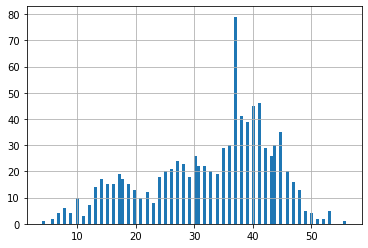

In [ ]:
import matplotlib.pyplot as plt
plt.hist(word_counts.values, bins=100)
plt.grid(True)
plt.show()

__Observación:__  La mayor parte de reviews tienen entre 35 y 45 palabras.

---



## Procesamiento de Datos

In [ ]:
import re
import nltk
nltk.download('punkt') # At first you have to download these nltk packages.
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
stop_words = stopwords.words('spanish') # definiendo stop_words
stop_words.remove('no') # remueve la palabra "no" para evitar que desaparezan de los comentarios negativos
lemmatizer = WordNetLemmatizer()

In [ ]:
stop_words

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro',
 'vue

In [ ]:
def data_preprocessing(review):
    
  # data cleaning
  review = re.sub('@[^\s]+','',review)             #elimina username Twitter
  review = re.sub('http[^\s]+','',review)          #elimina URL's
  review = re.sub(re.compile('<.*?>'), '', review) #elimina html tags
  review = re.sub('[^A-Za-z0-9áéíóúÁÉÍÓÚ]+', ' ', review)    #solo considera palabras
  
  
  # lowercase
  review = review.lower()
  
  # tokenization
  tokens = nltk.word_tokenize(review) # converts review to tokens
  
  # stop_words removal
  review = [word for word in tokens if word not in stop_words] #removing stop words
  
  # lemmatization
  review = [lemmatizer.lemmatize(word) for word in review]
  
  # join words in preprocessed review
  review = ' '.join(review)
  
  return review

In [ ]:
#Preprocesamiento de los tweets
df['preprocessed_review'] = df['tweet'].apply(lambda review: data_preprocessing(review))
df.head()

,,tweet_dt,topic,id,username,name,tweet,like_count,reply_count,retweet_count,retweeted,Etiqueta,preprocessed_review
0,2122,25/06/2020,Clinicas peru,1.28E+18,patoliberta,Patricio Sánchez 🐍,"""Martín Vizcarra advirtió que las clínicas pri...",0,0,0,FALSE,1,martín vizcarra advirtió clínicas privadas per...
1,3396,24/06/2020,Clinicas peru,1.28E+18,Doncito05,Lalito Cynara,@otravezandres @SAYSAYSAYSA @elcomercio_peru @...,2,0,0,FALSE,1,salud cualquier lugar mundo costos alto perú n...
2,3179,24/06/2020,Clinicas peru,1.28E+18,rochi1529,Rochi 🇵🇪🐩🐕🐈,@elbuho_pe @MartinVizcarraC @Minsa_Peru El pre...,0,0,0,FALSE,1,presidente elar salud peruanos clínicas no deb...
3,678,25/06/2020,Clinicas peru,1.28E+18,PedroSanchezH,Pedro Sánchez,Vizcarra destaca acuerdo con clínicas privadas...,0,0,0,FALSE,1,vizcarra destaca acuerdo clínicas privadas vol...
4,3412,24/06/2020,Clinicas peru,1.28E+18,Cuchiparrilla,🙂 Chicha de Jora 🍺,¿Qué espera señor Presidente @MartinVizcarraC?...,0,0,0,FALSE,1,espera or presidente debe usarse toda clínicas


#### Nube de palabras de los reviews positivos

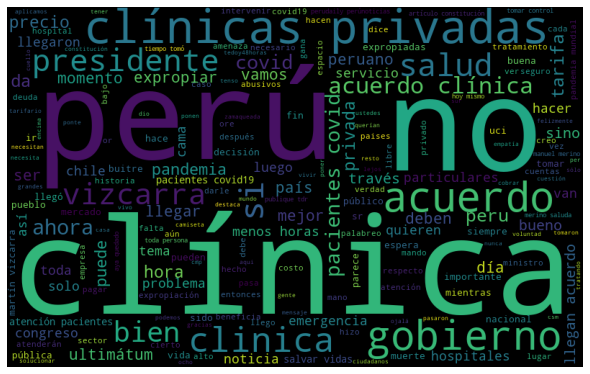

In [ ]:
from wordcloud import WordCloud

words_list = df[df['Etiqueta']==1]['preprocessed_review'].unique().tolist()
pos_words = " ".join(words_list)

pos_wordcloud =  WordCloud(
                  width=800, height = 500,            
                  stopwords=stop_words).generate(pos_words)

plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

#### Nube de palabras de los reviews negativos

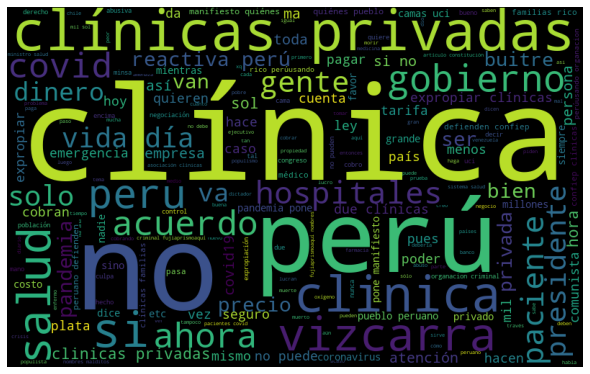

In [ ]:
words_list = df[df['Etiqueta']==0]['preprocessed_review'].unique().tolist()
neg_words = " ".join(words_list)

neg_wordcloud =  WordCloud(
                  width=800, height = 500,            
                  stopwords=stop_words).generate(neg_words)

plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(neg_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Dividiendo los datos (70% / 30%): Train | Test

In [ ]:
#from sklearn.model_selection import train_test_split

#data = df.copy()
#y = data['Etiqueta'].values
#data.drop(['Etiqueta'], axis=1, inplace=True)

#X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, stratify=y)

#print("Train data:",  X_train.shape, y_train.shape)
#print("Test data:",  X_test.shape, y_test.shape)

## Vectorizando el texto

#### BOW

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df=10)

X_train_review_bow = vect.fit_transform(X_train['preprocessed_review'])
X_test_review_bow = vect.transform(X_test['preprocessed_review'])

print('X_train_review_bow shape: ', X_train_review_bow.shape)
print('X_test_review_bow shape: ', X_test_review_bow.shape)

X_train_review_bow shape:  (645, 159)
X_test_review_bow shape:  (277, 159)


In [ ]:
import numpy as np
arreglo =  np.array(X_train_review_bow)
arreglo = X_train_review_bow.toarray
X_train['preprocessed_review']


705    jesús arapa roque integrante comisión salud in...
510    clínicas privadas peru organizaciones no puede...
892    llueve mojan incluso clínicas privadas sido gr...
770    países clínicas pusieron disposición no espero...
85     beneficio debería llegar cada peruano final go...
411    clínicas exigen si pague s 97 mil pacientes uc...
455    soberbia miseria humana asociación clínicas pr...
796       pueden copiar río revuelto ganancia pescadores
578    presidente perú advierte clínicas si no colabo...
308    peru ningun sol esalud clinicas privadas buroc...
526    víctor zamora titular indigna afán lucro medio...
297    dice chile irlanda etc tomado administración c...
862    perú intervendrá clínicas privadas si no reduc...
915                 paso alcanzara expropiación clinicas
285    no puede ejecutar presupuesto gente pretendien...
380    bueno q futuro gobierno debe hacer controlar s...
652                      tomar control clínicas gobierno
138    ud sabe maneras haber en

#### TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10)

X_train_review_tfidf = vectorizer.fit_transform(X_train['preprocessed_review'])
X_test_review_tfidf = vectorizer.transform(X_test['preprocessed_review'])

print('X_train_review_tfidf shape: ', X_train_review_tfidf.shape)
print('X_test_review_tfidf shape: ', X_test_review_tfidf.shape)

X_train_review_tfidf shape:  (645, 159)
X_test_review_tfidf shape:  (277, 159)


## Entrenando los Modelos

En esta parte del proyecto se utilizaran 3 clasificadores: Naive Bayes (variantes BOW y TFDIF) y Regresión Logística.

Luego del etiquetado de los tweets sobre la percepción del acuerdo del gobierno con las clínicas privadas, se observó que las clases (0: percepción negativa, 1: percepción positiva) están desbalanceadas. En todo el set de datos Se tiene aproximadamente **17%** de clases **positivas** y **83%** de clases **negativas**

#### Ajuste de Pesos
Debido a que se tienen mayores clases negativas, se le dará mayor peso a las clases positivas con la finalidad de optimizar el resultado de los clasificadores

In [ ]:
#Arreglo de pesos. La primera entrada le dará un peso reducido a las clases negativas y mayor a las clases positivas
#Los valores guardan relación con los porcentajes de participación de cada una de las clases en el dataset.
t_weight = np.array([1/0.83,1/0.17])

#### Naive Bayes: BOW

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

clf = MultinomialNB()
#Durante el entrenamiento se proveen los pesos de las clases negativas y positivas
clf.fit(X_train_review_bow, y_train, sample_weight=t_weight[y_train])
y_pred = clf.predict(X_test_review_bow)
print('Test Accuracy: ', accuracy_score(y_test, y_pred)) 
print('Test Precision: ', metrics.precision_score(y_test, y_pred))

Test Accuracy:  0.6895306859205776
Test Precision:  0.3148148148148148


##### Curva ROC - Naive Bayes: BOW 

AUC = 0.7894786373047243


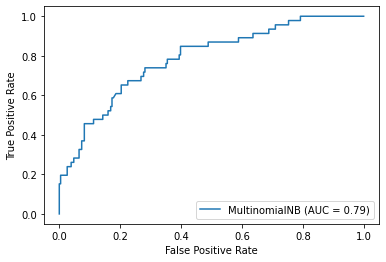

In [ ]:
from sklearn import metrics
# Obtiene las probabilidades de los valores a predecir
y_pred_test = clf.predict_proba(X_test_review_bow)[:,1]
auc_roc = metrics.roc_auc_score(y_test, y_pred_test)
print('AUC =', auc_roc)

metrics.plot_roc_curve(clf, X_test_review_tfidf, y_test)
plt.show()

##### Matriz de Confusion - Naive Bayes: BOW

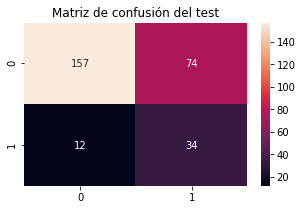

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Matriz de confusión del test')
plt.show()

#### Naive Bayes: TFIDF

In [ ]:
clf = MultinomialNB(alpha=1)
#Durante el entrenamiento se proveen los pesos de las clases negativas y positivas
clf.fit(X_train_review_tfidf, y_train, sample_weight=t_weight[y_train])
y_pred = clf.predict(X_test_review_tfidf)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))
print('Test Precision: ', metrics.precision_score(y_test, y_pred))


Test Accuracy:  0.7256317689530686
Test Precision:  0.3469387755102041


##### Curva ROC - Naive Bayes: TFIDF 

AUC = 0.8104648974214191


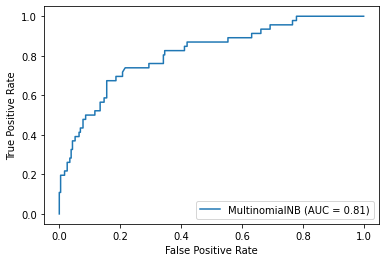

In [ ]:
from sklearn import metrics
# Obtiene las probabilidades de los valores a predecir
y_pred_test = clf.predict_proba(X_test_review_tfidf)[:,1]
auc_roc = metrics.roc_auc_score(y_test, y_pred_test)
print('AUC =', auc_roc)

metrics.plot_roc_curve(clf, X_test_review_tfidf, y_test)
plt.show()

##### Matriz de Confusion - Naive Bayes: TFIDF
La matriz de confusión muestra que se tiene una significativa cantidad de comentarios negativos clasificados como positivos lo que finalmente va en desmedro de la exactitud de la clasificación

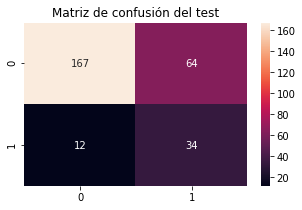

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Matriz de confusión del test')
plt.show()

#### Logistic Regression: TFIDF

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='l2')
#Durante el entrenamiento se proveen los pesos de las clases negativas y positivas
clf.fit(X_train_review_tfidf, y_train, sample_weight=t_weight[y_train])
y_pred = clf.predict(X_test_review_tfidf)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))

Test Accuracy:  0.7833935018050542


##### Curva ROC - Logistic Regression: TFIDF

AUC = 0.8132881611142481


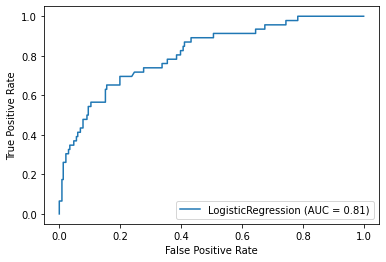

In [ ]:
from sklearn import metrics
# Obtiene las probabilidades de los valores a predecir
y_pred_test = clf.predict_proba(X_test_review_tfidf)[:,1]

auc_roc = metrics.roc_auc_score(y_test, y_pred_test)
print('AUC =', auc_roc)
metrics.plot_roc_curve(clf, X_test_review_tfidf, y_test)
plt.show()

La anterior curva ROC nos muestra que la regresión logística es el mejor clasificador de sentimiento con respecto a los otras 2 clasificadores (Naive Bayes BOW/TFIDF).
Lo que corresponde ahora es obtener el mejor Threshold que permita optimizar el par ***TPR*** y ***FPR***

In [ ]:
pd.set_option('display.max_rows', None)
#Obtiene de la curva ROC: Tasa de falsos positivos, Tasa de verdaderos positivo y threshold
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_test)
i = np.arange(len(tpr)) 
#La diferencia absoluta  entre la sensibilidad (TPR) y la especificidad (1-FPR) debe ser el más cercano a 0 para elegir ese thresold 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
#Ordena las diferencias entre sensibilidad y especificidad de menor a mayor
roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
#Obtien el mejor threshold para la clasificación
threshold = roc_t.iloc[0,1]
threshold

0.42942176303172985

In [ ]:
#Se obtiene las nuevas predicciones basadas en el mejor threshold. "y_pred_test" contiene las probabilidades para 
#la clasificación
y_pred_new = np.where(y_pred_test > threshold, 1, 0)


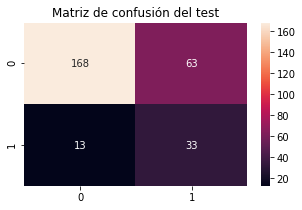

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_new)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Matriz de confusión del test')
plt.show()

In [ ]:
print('Test Precision: ', metrics.precision_score(y_test, y_pred_new))
print('Test Accuracy: ', metrics.accuracy_score(y_test, y_pred_new))
print('Test Recall: ', metrics.recall_score(y_test, y_pred_new))

Test Precision:  0.34375
Test Accuracy:  0.7256317689530686
Test Recall:  0.717391304347826


## Resumen de Resultados

In [ ]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ['Vectorizer', 'Model', 'Accuracy','Precision']
x.add_row(['BOW', 'Naive Bayes', '68.95%','31.48%'])
x.add_row(['TFIDF', 'Naive Bayes', '72.56%','34.69%'])
x.add_row(['TFIDF', 'Logistic Regression', '72.56%','34.38%'])
print(x)

+------------+---------------------+----------+-----------+
| Vectorizer |        Model        | Accuracy | Precision |
+------------+---------------------+----------+-----------+
|    BOW     |     Naive Bayes     |  68.95%  |   31.48%  |
|   TFIDF    |     Naive Bayes     |  72.56%  |   34.69%  |
|   TFIDF    | Logistic Regression |  72.56%  |   34.38%  |
+------------+---------------------+----------+-----------+


Text(0, 0.5, 'Porcentaje de percepción')

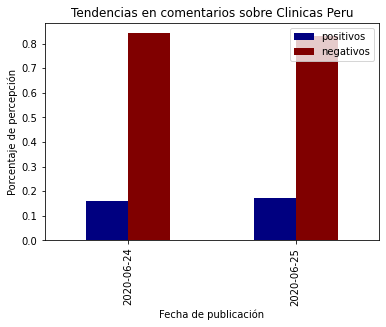

In [ ]:
import numpy as np
df_percents = pd.DataFrame(columns=['tweet_dt','positivos','negativos'])
for i in np.sort(pd.unique(df.tweet_dt)):
  array_percents = (df[df.tweet_dt==i].groupby('Etiqueta').count()/df[df.tweet_dt==i].count())['id']
  dict_to_append = {
                                "tweet_dt": pd.to_datetime(i).date(),
                                "positivos":array_percents[1],
                                "negativos":array_percents[0]
                    }
  df_percents = df_percents.append(dict_to_append, ignore_index=True)

ax = df_percents.plot(x = 'tweet_dt', kind='bar',lw=2, colormap='jet',  
                 title='Tendencias en comentarios sobre Clinicas Peru')
ax.set_xlabel("Fecha de publicación")
ax.set_ylabel("Porcentaje de percepción")